# Split conformal prediction for regression tutorial

Mikolaj Mazurczyk & Christian Igel, 2025.
Please let us know how to improve the notebook.

#### A standard way to estimate the performance of a predictive model:
* To estimate the expected accuracy of a model, we estimate its accuracy on an i.i.d. validation data set not used during training.
* In expectation over all draws of the validation data set, the mean accuracy on the validation data set equals the expected performance.
* To account for finite sample effects, we apply finite sample concentration bounds.

#### What about the following for estimating the uncertainty of a model:
* To estimate the uncertainty performance of a model, we estimate its uncertainty on an i.i.d. calibration data set not used during training.
* In expectation over all draws of the calibration data set, the $\alpha$-quantile of uncertainties on the calibration data should be the expected $\alpha$-quantile of uncertainty.
* To account for finite sample effects, we apply finite sample concentration bounds.

### Importing libraries & setting up the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from abc import ABC, abstractmethod
from scipy.spatial.distance import pdist

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}\\usepackage{amssymb}'
params = {'text.usetex' : True,
          'font.size' : 16,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params)

### Example problem

The underlying model is a simple power clipped function $f(x)=\min(0.1, ax^b)$ plus potentially heteroscedastic noise $\epsilon_x$ drawn from $\sigma_xN(0,1)$ with $\sigma_x=\sigma + x\cdot\sigma_{\text{inc}}$. The Python function returns the noise-free (true) function values $t(x)=f(x)$ and the noisy observations $y(x)=f(x)+\epsilon_x$.

In [3]:
def f(x, sigma = 0, sigma_inc = 0):
    n = len(x)  # number of samples
    a = 0.10  # scaling factor
    b = 2  # exponent
    t = a + np.power(x,b)  # true target values
    s = x * sigma_inc + sigma  # standard deviations potentially depending on x
    e = s * np.random.normal(0, 1, n)
    y = np.clip(t+e, a_min=0.01, a_max=None)
    return t, y

Generate a uniformly distributed calibration data set $\{(x_1,t_1,y_1),\dots, (x_n,t_n,y_n)\}$ and an evenly spaced test data set:

In [4]:
n_train_example = 100 # number of training data points
n_test_example = 500 # number of testing data points
n_cal_example = 100  # number of calibration data points
sigma_example = 10  # standard deviation of noise
sigma_inc_example = 1.5  # noise increase

# Training set
x_train_example = np.sort(np.random.uniform(0, 10, n_train_example))
_, y_train_example = f(x_train_example, sigma_example, sigma_inc_example)
# Calibration set
x_cal_example = np.sort(np.random.uniform(0, 10, n_cal_example))
_, y_cal_example = f(x_cal_example, sigma_example, sigma_inc_example)
# Evenly spaced test data
x_test_example = np.linspace(0, 10, n_test_example)
t_test_example, y_test_example = f(x_test_example, sigma_example, sigma_inc_example)

x_train_example, y_train_example = torch.tensor(x_train_example), torch.tensor(y_train_example)
x_cal_example, y_cal_example = torch.tensor(x_cal_example), torch.tensor(y_cal_example)
x_test_example, y_test_example = torch.tensor(x_test_example), torch.tensor(y_test_example)

alpha_example = 0.1  # significance level for conformal prediction

### Defining the model and a function for fitting it
The model is a power regression model $\hat{f}(x)=ax^b$.


In [5]:
class PowerRegressionModel(torch.nn.Module):
    def __init__(self, factor:float =1., exponent:float =1.):
        super(PowerRegressionModel, self).__init__()
        self.a = torch.nn.Parameter(torch.tensor(factor))
        self.b = torch.nn.Parameter(torch.tensor(exponent))

    def forward(self, x):
        y = self.a * torch.pow(x, self.b)
        return y

We fit the model in log space (which is not uncommon) to get a pronounced asymmetric error distribution.
That is, the pointwise loss function is $\ell(y,\hat{y}) = (\ln y -\ln \hat{y})^2$.

In [6]:
def fit_power(x, y, a=1., b=1., lr=0.01, num_epochs = 2000, verbose=False):
    model = PowerRegressionModel(factor=a, exponent=b)
    model.train()
    mse = nn.MSELoss()
    optimizer = torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.1), step_sizes=(0, 5))

    for epoch in range(num_epochs):
        y_pred = model(x)
        loss= mse(torch.log(y_pred), torch.log(y))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if(verbose):
            print('epoch {}, RMSE {}'.format(epoch, torch.sqrt(loss).item()))
    return model

In [7]:
model_example = fit_power(x_train_example, y_train_example, verbose=False)

In [8]:
print("Model parameters: (", model_example.a.item(), ",", model_example.b.item(), ")")

Model parameters: ( 0.21115779876708984 , 2.2900757789611816 )


Evaluate the model on training, calibration, and test data:

In [9]:
with torch.no_grad():
    y_model_train_example = model_example(x_train_example)
    y_model_cal_example = model_example(x_cal_example)
    y_model_test_example = model_example(x_test_example)

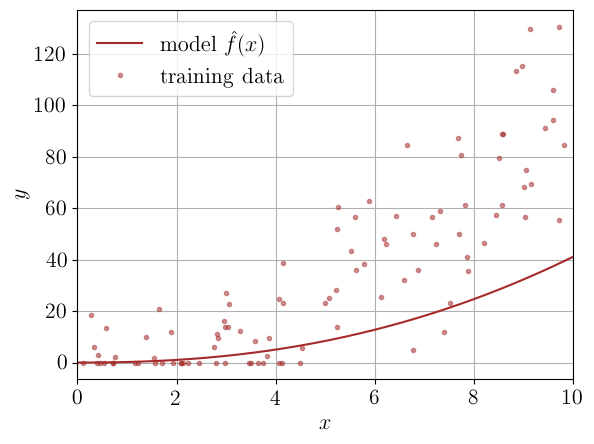

In [10]:
def plot_model_predictions(x_test, y_model_test, x_train, y_train, x_cal=None, y_cal=None, filename=None):
    plt.plot(x_test, y_model_test, label="model $\\hat{f}(x)$", color="brown")
    plt.plot(x_train, y_train, '.', label="training data", alpha=0.5, color="brown")
    plt.grid()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.margins(x=0)
    plt.legend(loc=2)
    if(filename):
        plt.savefig(filename, bbox_inches='tight')

plot_model_predictions(x_test_example, y_model_test_example, x_train_example, y_train_example, filename="figures/allo_model.png")

### Basic idea of (split) conformal prediction (SCP)
This is based on the tutorial by Anastasios N. Angelopoulos and Stephen Bates (2023), “Conformal Prediction: A Gentle Introduction”, *Foundations and Trends® in Machine Learning* 16(4):494–591. DOI: [10.1561/2200000101](http://dx.doi.org/10.1561/2200000101).

#### Basic conformal prediction scheme:

1. Identify a heuristic notion $u(x)$ of uncertainty using the pre-trained model
2. Define the score function $s(x, y)$, where larger scores encode worse agreement between $x$ and $y$
3. Compute $\hat{q}$ as the $\frac{\lceil (n+1)(1−\alpha)\rceil}{n}$
quantile of the calibration scores $\{s_i,\dots, s_n\}$ with $s_i = s(x_i, y_i)$
4. Use this quantile to form the prediction sets for new examples:
$$
\mathcal{C}(x)=\{ y:s(x,y) \le \hat{q} \}
$$

In [11]:
class BaseSCP(ABC):
    def __init__(self, alpha):
        self.alpha = alpha
        self.emp_q = None
        self.x_cal = None
        self.y_cal = None
        self.cal_scores = None

    @abstractmethod
    def score(self, x, y):
        pass

    def fit(self, x_cal, y_cal):
        n = len(x_cal)
        k = int(np.ceil((n + 1) * (1 - self.alpha)))
        scores = self.score(x_cal, y_cal)
        scores, _ = torch.sort(scores)
        self.x_cal = x_cal
        self.y_cal = y_cal
        self.cal_scores = scores
        if k > n:
            self.emp_q = torch.inf
        else:
            self.emp_q = scores[k - 1]  # -1 for zero-based indexing

    @abstractmethod
    def predict(self, x_test):
        pass

### Absolute error SCP

First, assume we have no information about the uncertainty ($u(x)=\text{const}$) and we simply define
$s(x,y)=|y-f(x)|$:

In [12]:
class AbsoluteErrorSCP(BaseSCP):
    def __init__(self, model, alpha):
        self.model = model
        super().__init__(alpha)

    def score(self, x, y):
        with torch.no_grad():
            return torch.abs(y - self.model(x))

    def predict(self, x_test):
        with torch.no_grad():
            y_test_pred = self.model(x_test)
        return y_test_pred - self.emp_q, y_test_pred + self.emp_q

In [13]:
abs_err_scp = AbsoluteErrorSCP(model_example, alpha_example)
abs_err_scp.fit(x_cal_example, y_cal_example)
abs_err_scp_prediction_sets = abs_err_scp.predict(x_test_example)

Visualize the absolute error scores:

In [14]:
def plot_absolute_error_scores(x_test, y_model_test, x_cal, y_cal, y_model_cal, filename=None):
    plt.plot(x_test, y_model_test, label="model $\\hat{f}(x)$", color="brown")
    plt.plot(x_cal, y_model_cal, '.', color="brown")
    plt.plot(x_cal, y_cal, '.', label=r"calibration data $\mathcal{D}_{\text{cal}}$", alpha=0.5, color="green")

    plt.plot(np.vstack([x_cal, x_cal]), np.vstack([y_cal, y_model_cal]), '-', color='lightgreen', zorder=0)
    plt.plot([],[], color="tab:green", label='scores $s(x,y)=|y-\\hat{f}(x)|$')
    plt.grid();
    plt.xlabel("$x$");
    plt.ylabel("$y$");
    plt.margins(x=0)
    plt.legend(loc=2);
    if filename:
        plt.savefig(filename, bbox_inches='tight');

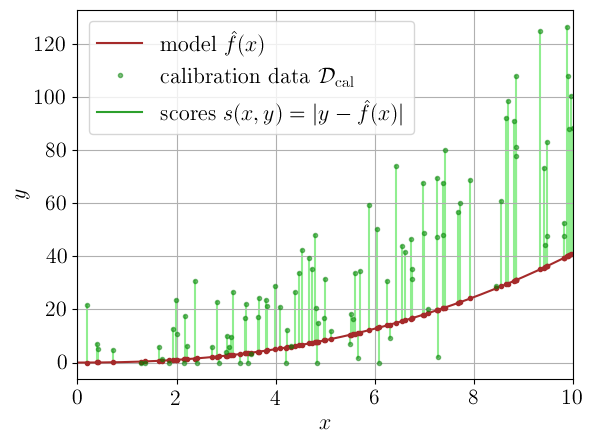

In [15]:
plot_absolute_error_scores(
    x_test_example,
    y_model_test_example,
    x_cal_example, 
    y_cal_example,
    y_model_cal_example,
    filename="figures/abs_err_scp_s.png"
)

Visualize the empirical cumulative distribution function of the scores and the threshold given by $\hat{q}$:

In [16]:
def plot_cdf(data, cdf, ax, color="tab:green"):
    ax.hlines(y=cdf[:-1], xmin=data[:-1], xmax=data[1:], color=color, zorder=1)
    ax.vlines(
        x=data,
        ymin=np.insert(cdf, 0, 0)[:-1],
        ymax=cdf,
        color=color,
        linestyle='dotted',
        zorder=1
    )
    ax.scatter(data, cdf, color=color, s=18, zorder=2)
    ax.scatter(data, np.insert(cdf.numpy(), 0, 0)[:-1], color='white', s=18, zorder=2, edgecolor=color)

In [17]:
def plot_scp_cdf(scores, emp_q, alpha, filename=None, old_style=False):
    fig, ax = plt.subplots()
    scores, _ = torch.sort(scores)
    cdf = torch.arange(1, len(scores) + 1) / len(scores)
    #print(cdf.shape, scores.shape)
    
    if old_style:
        plt.hist(scores, bins=len(scores), 
                 alpha=0.7, color="tab:green", edgecolor="tab:green", density=True, cumulative=True)
        plt.margins(x=0)
    else:
        plot_cdf(scores, cdf, ax)
    
    ax.axvline(
        emp_q,
        color='red',
        linestyle='dashed',
        linewidth=1,
        label=r'$\hat{q}$ for $\alpha=$' + f'{alpha}'  
    )
    n = len(scores)
    coverage_level = (1 - alpha) * (n + 1) / n
    ax.axhline(
        coverage_level,
        color='tab:orange',
        linestyle='dashed',
        linewidth=1,
        label=r'$(1-\alpha)(n+1)/n$'
    )
    ax.set_xlabel(r"scores $\{s_i\}_{i=1}^n$")
    ax.set_ylabel("cumulative probability")
    ax.grid(True)
    ax.legend(loc=4)
    if(filename):
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

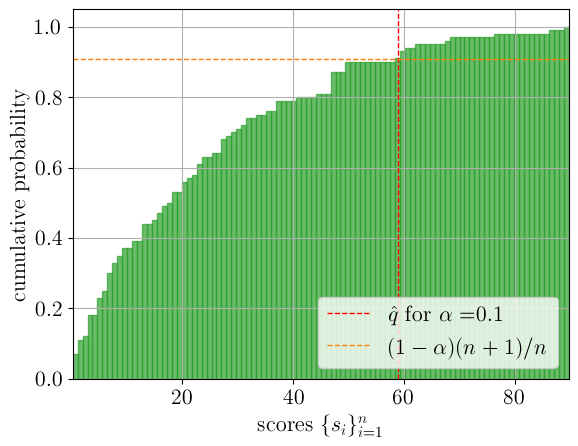

In [18]:
#plot_scp_cdf(abs_err_scp.cal_scores, abs_err_scp.emp_q, alpha_example)
plot_scp_cdf(abs_err_scp.cal_scores, abs_err_scp.emp_q, alpha_example, filename="figures/abs_err_scp_cdf.png", old_style=True)

Visualize the predictions and the prediction sets:

In [19]:
def plot_scp_predictions(x_test, y_test, y_model_test, prediction_sets, alpha, filename=None):
    plt.plot(x_test, y_model_test, label="model", color="brown")
    plt.plot(x_test, y_test, '.', label="test data", alpha=0.5)
    plt.fill_between(
        x_test, prediction_sets[0], prediction_sets[1], alpha=0.2, label=r"$\alpha=\;$%.2f prediction interval" % alpha
    )
    plt.grid()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()
    plt.margins(x=0)
    if filename:
        plt.savefig(filename, bbox_inches='tight')

torch.Size([500]) torch.Size([500]) torch.Size([500])


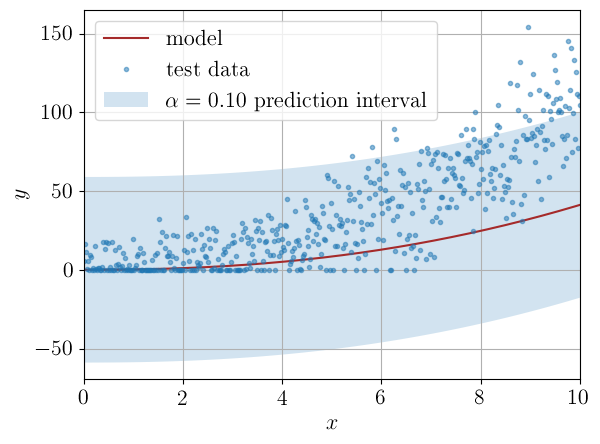

In [20]:
print(x_test_example.shape, abs_err_scp_prediction_sets[0].shape, abs_err_scp_prediction_sets[1].shape)

plot_scp_predictions(
    x_test_example,
    y_test_example,
    y_model_test_example,
    abs_err_scp_prediction_sets,
    alpha_example,
    filename="figures/abs_err_scp_predictions.png"
)

For evaluation, we check the coverage of the prediction sets and the average width of the prediction sets:

In [21]:
def eval_scp(prediction_sets, y_test):
    lower, upper = prediction_sets
    coverage = (torch.greater_equal(y_test, lower) & torch.greater_equal(upper, y_test)).float().mean().item()
    width = torch.mean(upper - lower).item()
    return coverage, width

def print_eval_stats(eval_stats):
    for method_name, stats in eval_stats.items():
        coverage, width = stats
        print(method_name)
        print(f"Coverage: {coverage:.2f}, Average width: {width:.2f}\n")

In [22]:
eval_stats_example = {"Absolute Error SCP": eval_scp(abs_err_scp_prediction_sets, y_test_example)}
print_eval_stats(eval_stats_example)

Absolute Error SCP
Coverage: 0.90, Average width: 117.86



### Signed-Error SCP

The absolute error SCP is not adaptive to asymmetric error distributions, i.e., it does not distinguish between over- and under-predictions. To address this, we can use the signed error as the score function, which allows us to adapt the prediction sets to the distribution of errors.

To make the method adaptable to asymmetric error distributions, we can replace the score with asymmetric conformal bands. Specifically, instead of defining $s(x,y)=|y-\hat{f}(x)|$, two separate scores are used
$$
    s_{i,\text{lo}} = s_{\text{lo}}(x_i,y_i) =  \hat{f}(x_i) -  y_i, \quad s_{i,\text{hi}} = s_{\text{hi}}(x_i,y_i) = y_i - \hat{f}(x_i),
$$
for which we run the conformal prediction at two miscoverage levels $\alpha_{\text{lo}},\alpha_{\text{hi}}$, resulting in $\hat{q}_{\alpha_{\text{lo}}}$ and $\hat{q}_{\alpha_{\text{hi}}}$, and since both are valid score function we have that
\begin{equation*}
\begin{split}
    \mathbb{P}(Y_{\text{test}} \in \mathcal{C}_{\text{lo}} (X_{\text{test}})) &= \mathbb{P}(Y_{\text{test}} \geq \hat{f}(X_{\text{test}}) - \hat{q}_{\alpha_{\text{lo}}}) \geq 1-\alpha_{\text{lo}},\\
    \mathbb{P}Y_{\text{test}} \in \mathcal{C}_{\text{hi}} (X_{\text{test}})) &= \mathbb{P}(Y_{\text{test}} \leq \hat{f}(X_{\text{test}}) + \hat{q}_{\alpha_{\text{hi}}}) \geq 1-\alpha_{\text{hi}}.
\end{split}
\end{equation*}
Importantly, if we define the final confidence set as
$$
    \mathcal{C}(X_{\text{test}}) = [\hat{f}(X_{\text{test}})-\hat{q}_{\alpha_{\text{lo}}}, \hat{f}(X_{\text{test}}) + \hat{q}_{\alpha_{\text{hi}}}]
$$
and $\alpha = \alpha_{\text{lo}} + \alpha_{\text{hi}}$, by the union bound on miscoverage probability we get
$$
    \mathbb{P}(Y_{\text{test}}\in\mathcal{C}(X_{\text{test}})) \geq 1-\alpha.
$$

The method was introduced by H. Linusson, U. Johansson, and T. Löfström. "Signed-error conformal regression." *Advances in Knowledge Discovery and Data Mining (PKDD)*, 224–236, 2014.

In [23]:
class SignedErrorSCP:
    class OneSidedSCP(BaseSCP):
        def __init__(self, alpha):
            super().__init__(alpha)

        def score(self, y, y_pred):
            return y_pred - y

        def predict(self, x):
            pass

    def __init__(self, model, alpha_lo, alpha_hi):
        self.model = model
        self.alpha_lo = alpha_lo
        self.alpha_hi = alpha_hi
        self.x_cal = None
        self.y_cal = None
        self.scp_lo = None
        self.scp_hi = None

    def fit(self, x_cal, y_cal):
        self.x_cal = x_cal
        self.y_cal = y_cal
        with torch.no_grad():
            y_cal_pred = self.model(x_cal)

        # Fit lower bound SCP
        self.scp_lo = self.OneSidedSCP(self.alpha_lo)
        self.scp_lo.fit(y_cal, y_cal_pred)

        # Fit upper bound SCP
        self.scp_hi = self.OneSidedSCP(self.alpha_hi)
        self.scp_hi.fit(-y_cal, -y_cal_pred)

    def predict(self, x_test):
        with torch.no_grad():
            y_test_pred = self.model(x_test)
        return y_test_pred - self.scp_lo.emp_q, y_test_pred + self.scp_hi.emp_q

In [24]:
print(x_cal_example.shape, y_cal_example.shape, x_test_example.shape)

signed_err_scp = SignedErrorSCP(model_example, alpha_example / 2, alpha_example / 2)
signed_err_scp.fit(x_cal_example, y_cal_example)
signed_err_scp_prediction_sets = signed_err_scp.predict(x_test_example)

torch.Size([100]) torch.Size([100]) torch.Size([500])


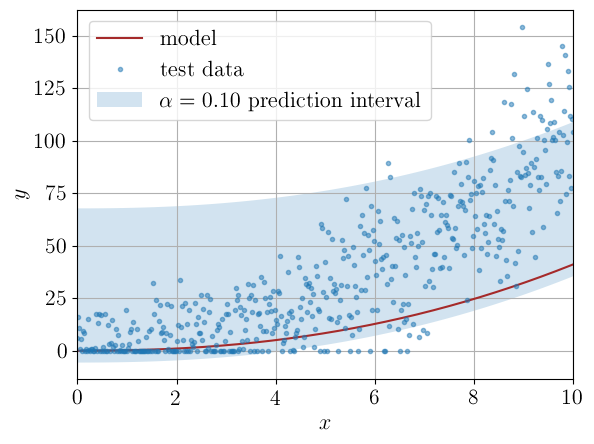

In [25]:
plot_scp_predictions(
    x_test_example,
    y_test_example,
    y_model_test_example,
    signed_err_scp_prediction_sets,
    alpha_example,
    filename="figures/signed_err_scp_predictions.png"
)

In [26]:
eval_stats_example["Signed Error SCP"] = eval_scp(signed_err_scp_prediction_sets, y_test_example)
print_eval_stats(eval_stats_example)

Absolute Error SCP
Coverage: 0.90, Average width: 117.86

Signed Error SCP
Coverage: 0.91, Average width: 73.46



### Scaled residual SCP
So far, the uncertainty estimate was independent of $x$.

Let's make the score $s(x, y)$ depend on $u(x)$, say
$$
s(x,y)=\frac{|y-f(x)|}{u(x)}\enspace.
$$
Then when going from $\hat{q}$ to the prediction interval for some $x$
then the $\hat{q}$ is scaled by $u(x)$.

This is an important setting for conformal prediction, because it allows to calibrate uncertainty estimates ($u(x)$) coming from another method.

Let's assume we know that we have an estimator $\hat{l}(x)$ of the logarithm of the heteroscedastic noise variance.
We can learn an estimator of the noise variance using the <code>GaussianNLLLoss</code> loss function. To ensure positivity of the variance, we encode it by its logarithm.

Given an estimate of the variance, we can use the estimated standard deviation as uncertainty estimate $u(x)=\sqrt{\exp{\hat{l}}}$ to define
$s(x,y)=\frac{|y-f(x)|}{u(x)}= \frac{|y-f(x)|}{\sqrt{\exp{\hat{l}}}}$:

In [46]:
class ScaledResidualLogVarSCP(BaseSCP):
    def __init__(self, model, model_logvar, alpha):
        self.model = model
        self.model_logvar = model_logvar
        super().__init__(alpha)

    def score(self, x, y):
        with torch.no_grad():
            y_hat = self.model(x)
            log_var = self.model_logvar(x)
            u = torch.sqrt(torch.exp(log_var))
            return torch.abs(y - y_hat) / u 

    def predict(self, x_test):
        with torch.no_grad():
            y_test_pred = self.model(x_test)
            y_test_logvar = self.model_logvar(x_test)
            u_test = torch.sqrt(torch.exp(y_test_logvar))
        return y_test_pred - self.emp_q * u_test, y_test_pred + self.emp_q * u_test

To get estimator $\hat{l}(x)$ of the logarithm of the heteroscedastic noise variance, 
we train an MLP using the <code>GaussianNLLLoss</code> loss function.

D. A. Nix and A. S. Weigend. Estimating the mean and variance of the target
probability distribution. *International Conference on Neural Networks (ICNN)*,
vol. 1. IEEE. 55–60, 1994.

In [28]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim=1, n_hidden=16):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_dim, n_hidden)
        self.log_var = nn.Linear(n_hidden, 1)

    def forward(self, x):
        if x.dim()==1:
            x=x.view(-1,1)
        x = nn.functional.elu(self.hidden(x))
        log_var = self.log_var(x)
        return torch.squeeze(log_var)

def fit_log_var_MLP(x, y, model, lr=0.01, num_epochs = 2000, verbose=False):
    model_log_var = MLP()

    criterion = nn.GaussianNLLLoss()
    optimizer = torch.optim.Rprop(model_log_var.parameters(), lr=lr, etas=(0.5, 1.1), step_sizes=(0, 5))

    for epoch in range(num_epochs):
        with torch.no_grad():
            y_pred = model(x)
        log_var = model_log_var(x)
        var = torch.exp(log_var)  # Convert log-variance to variance
        loss = criterion(y_pred, y, var)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return model_log_var

In [29]:
torch.set_default_dtype(torch.float64)
model_log_var = fit_log_var_MLP(x_train_example, y_train_example, model_example)

In [30]:
scaled_res_scp = ScaledResidualLogVarSCP(model_example, model_log_var, alpha_example)
scaled_res_scp.fit(x_cal_example, y_cal_example)
scaled_res_scp_prediction_sets = scaled_res_scp.predict(x_test_example)

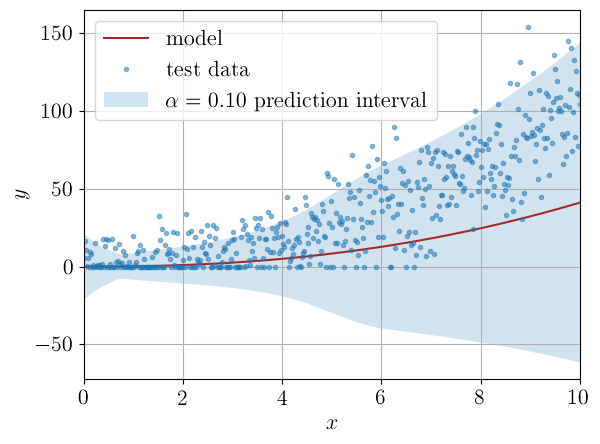

In [31]:
plot_scp_predictions(
    x_test_example,
    y_test_example,
    y_model_test_example,
    scaled_res_scp_prediction_sets,
    alpha_example,
    filename="figures/scaled_res_scp_predictions.png"
)

In [32]:
eval_stats_example["Scaled Residual SCP"] = eval_scp(scaled_res_scp_prediction_sets, y_test_example)
print_eval_stats(eval_stats_example)

Absolute Error SCP
Coverage: 0.90, Average width: 117.86

Signed Error SCP
Coverage: 0.91, Average width: 73.46

Scaled Residual SCP
Coverage: 0.87, Average width: 86.51



### Conformalized Quantile Regression (CQR)

Conformalized Quantile Regression (CQR) is a method that uses quantile regression to estimate the lower and upper bounds of the prediction sets. It fits two quantile regression models, one for the lower quantile and one for the upper quantile, and uses these models to form the prediction sets.

We fit the quantile regression models using the pinball loss
$$
\ell_{\text{pinball}}(y, \hat{f}(x)) = \max(\tau(y - \hat{f}(x)), (1-\tau)(\hat{f}(x) - y)),
$$
where $\tau$ is the quantile level.

In [33]:
class PinballLoss(nn.Module):
    def __init__(self, quantile: float):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        errors = y_true - y_pred
        loss = torch.max(self.quantile * errors, (self.quantile - 1) * errors)
        return torch.mean(loss)

def fit_power_quantile(x, y, q, a=1., b=1., lr=0.01, num_epochs = 2000, verbose=False):
    model = PowerRegressionModel(factor=a, exponent=b)

    criterion = PinballLoss(q)
    optimizer = torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.1), step_sizes=(0, 5))

    for epoch in range(num_epochs):
        y_pred = model(x)
        loss = criterion(torch.log(y_pred), torch.log(y))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if verbose:
            print('epoch {}, RMSE {}'.format(epoch, torch.sqrt(loss).item()))
    return model

In [34]:
lower_q_model_example = fit_power_quantile(x_train_example, y_train_example, 0.05, verbose=False)
upper_q_model_example = fit_power_quantile(x_train_example, y_train_example, 0.95, verbose=False)

Define the CQR class that uses the two quantile regression models to form the prediction sets:

In [35]:
class CQR(BaseSCP):
    def __init__(self, lower_q_model, upper_q_model, alpha):
        super().__init__(alpha)
        self.lower_q_model = lower_q_model
        self.upper_q_model = upper_q_model

    def score(self, x, y):
        with torch.no_grad():
            lower_q_pred = self.lower_q_model(x)
            upper_q_pred = self.upper_q_model(x)
        return torch.maximum(lower_q_pred - y, y - upper_q_pred)

    def predict(self, x):
        with torch.no_grad():
            lower_q_pred = self.lower_q_model(x)
            upper_q_pred = self.upper_q_model(x)
        return lower_q_pred - self.emp_q, upper_q_pred + self.emp_q

In [36]:
cqr = CQR(lower_q_model_example, upper_q_model_example, alpha_example)
cqr.fit(x_cal_example, y_cal_example)
cqr_prediction_sets = cqr.predict(x_test_example)

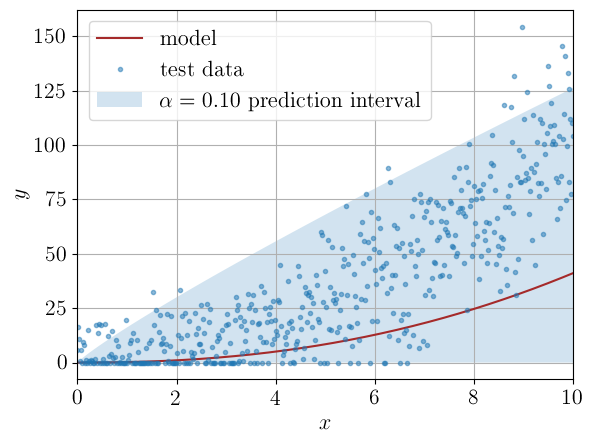

In [37]:
plot_scp_predictions(
    x_test_example,
    y_test_example,
    y_model_test_example,
    cqr_prediction_sets,
    alpha_example,
    filename="figures/cqr_predictions.png"
)

In [38]:
eval_stats_example["Conformalized Quantile Regression"] = eval_scp(cqr_prediction_sets, y_test_example)
print_eval_stats(eval_stats_example)

Absolute Error SCP
Coverage: 0.90, Average width: 117.86

Signed Error SCP
Coverage: 0.91, Average width: 73.46

Scaled Residual SCP
Coverage: 0.87, Average width: 86.51

Conformalized Quantile Regression
Coverage: 0.87, Average width: 66.71



### Split Localized Conformal Prediction (SLCP)

Split Localized Conformal Prediction (SLCP) is a method that combines the ideas of localization and split conformal prediction. It uses a kernel-based approach to compute weights for the training data, which allows it to adapt the quantile estimates to the local distribution of the data.

In [39]:
class SplitLocalizedCP:
    class LocalizedCP(BaseSCP):
        def __init__(self, alpha):
            super().__init__(alpha)

        def score(self, scores, localized_q):
            return scores - localized_q

        def predict(self, x):
            pass

    def __init__(self, model, alpha_lo, alpha_hi, kernel, kernel_bandwidth):
        self.model = model
        self.alpha_lo = alpha_lo
        self.alpha_hi = alpha_hi
        self.kernel = kernel
        self.kernel_bandwidth = kernel_bandwidth
        self.x_train = None
        self.y_train = None
        self.x_cal = None
        self.y_cal = None
        self.cp_q_lo = None
        self.cp_q_hi = None
        self.train_scores_lo = None

    def __compute_weights(self, x):
        if len(x.shape) == 1:
            x = x[:, None]  # Ensure x is 2D for consistency
        # print(x.shape)
        n_train = len(self.x_train)
        x_rep = x[:, None].repeat(1, n_train, 1)
        n = len(x)
        x_train_rep = self.x_train[None, :].repeat(n, 1, 1)
        # print(x_rep.shape, x_train_rep.shape)
        norms = torch.linalg.norm(x_rep - x_train_rep, dim=-1) / self.kernel_bandwidth
        k = self.kernel(norms.flatten()).reshape(n, n_train)
        # print(k)
        return k / k.sum(dim=1, keepdims=True)

    def __get_localized_q(self, weights, alpha, train_scores):
        train_s_arg_sorted = torch.argsort(train_scores)
        emp_cdf = torch.cumsum(weights[:, train_s_arg_sorted], dim=1)
        # print(weights)
        localized_q_indices = torch.argmax(((1-alpha) <= emp_cdf).float(), dim=1)
        localized_qs = train_scores[train_s_arg_sorted[localized_q_indices]]
        return localized_qs

    def __get_conformal_q(self, alpha, cal_scores, localized_qs):
        localized_cp = self.LocalizedCP(alpha)
        localized_cp.fit(cal_scores, localized_qs)
        return localized_cp.emp_q

    def fit(self, x_train, y_train, x_cal, y_cal):
        with torch.no_grad():
            self.train_scores_lo = self.model(x_train) - y_train
        if len(x_train.shape) == 1:
            x_train = x_train[:, None]  # Ensure x_train is 2D for consistency
        self.x_train = x_train
        weights = self.__compute_weights(x_cal)
        localized_q_lo = self.__get_localized_q(weights, self.alpha_lo, self.train_scores_lo)
        localized_q_hi = self.__get_localized_q(weights, self.alpha_hi, -self.train_scores_lo)
        # print(localized_q_lo, localized_q_hi)

        with torch.no_grad():
            cal_scores_lo = self.model(x_cal) - y_cal
        self.cp_q_lo = self.__get_conformal_q(self.alpha_lo, cal_scores_lo, localized_q_lo)
        self.cp_q_hi = self.__get_conformal_q(self.alpha_hi, -cal_scores_lo, localized_q_hi)
        # print(f"Localized CP quantiles: {self.cp_q_lo:.4f} (lo), {self.cp_q_hi:.4f} (hi)")

    def predict(self, x):
        with torch.no_grad():
            y_pred = self.model(x)
        weights = self.__compute_weights(x)
        localized_q_lo = self.__get_localized_q(weights, self.alpha_lo, self.train_scores_lo)
        localized_q_hi = self.__get_localized_q(weights, self.alpha_hi, -self.train_scores_lo)
        return y_pred - localized_q_lo - self.cp_q_lo, y_pred + localized_q_hi + self.cp_q_hi

Define the kernel function and a heuristic for choosing the bandwidth:

In [40]:
def gaussian_kernel(x):
    return 1 / torch.sqrt(torch.tensor(2 * torch.pi)) * torch.exp(-0.5 * x ** 2)

def compute_median_trick_bandwidth(features) -> float:
    # pdist computes the pairwise distances between all rows and returns a
    # condensed distance matrix (a 1D array).
    pairwise_distances = pdist(features, 'euclidean')

    # return the median of these distances.
    return np.median(pairwise_distances)

In [41]:
kernel_bandwidth_example = compute_median_trick_bandwidth(x_train_example[:, None])

In [42]:
print("kernel bandwidth:", kernel_bandwidth_example)

kernel bandwidth: 2.9708960734188636


In [43]:
slcp = SplitLocalizedCP(
    model=model_example,
    alpha_lo=alpha_example / 2,
    alpha_hi=alpha_example / 2,
    kernel=gaussian_kernel,
    kernel_bandwidth=kernel_bandwidth_example
)
slcp.fit(x_train_example, y_train_example, x_cal_example, y_cal_example)
slcp_prediction_sets = slcp.predict(x_test_example)

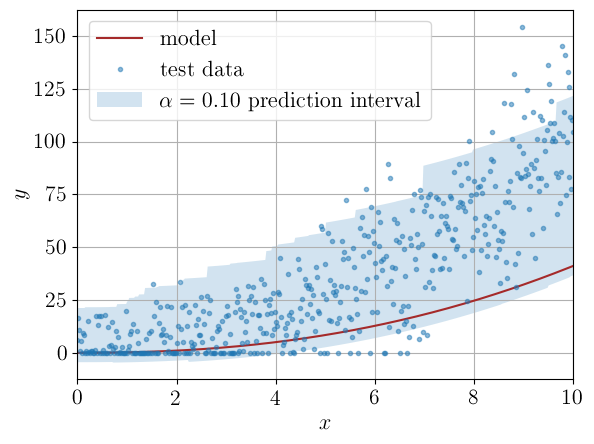

In [44]:
plot_scp_predictions(
    x_test_example,
    y_test_example,
    y_model_test_example,
    slcp_prediction_sets,
    alpha_example,
    filename="figures/slcp_predictions.png"
)

In [45]:
eval_stats_example["Split Localized Conformal Prediction"] = eval_scp(slcp_prediction_sets, y_test_example)
print_eval_stats(eval_stats_example)

Absolute Error SCP
Coverage: 0.90, Average width: 117.86

Signed Error SCP
Coverage: 0.91, Average width: 73.46

Scaled Residual SCP
Coverage: 0.87, Average width: 86.51

Conformalized Quantile Regression
Coverage: 0.87, Average width: 66.71

Split Localized Conformal Prediction
Coverage: 0.90, Average width: 55.74

